In [11]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

from pingouin import mixed_anova, pairwise_tests
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm, ols
import statsmodels.formula.api as smf
from astropy.stats import circcorrcoef
from statsmodels.stats.multitest import multipletests

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
common_fig_folder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/GRAB')
common_fig_folder.mkdir(exist_ok=True, parents=True)

grabda_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABDA2m',
                                         figfolder=common_fig_folder / 'GRABDA2m',
                                         id_suffix='DA')

graboa_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABOA1',
                                         figfolder=common_fig_folder / 'GRABOA1',
                                        id_suffix='OA')



In [7]:
da_stats_df = nmp.grab_sensors.offset_stats(grabda_sess)
da_stats_df_unique = nmp.grab_sensors.offset_stats_unique(da_stats_df)
da_stats_df_plot = nmp.grab_sensors.offset_stats_plot(da_stats_df_unique)

oa_stats_df = nmp.grab_sensors.offset_stats(graboa_sess)
oa_stats_df_unique = nmp.grab_sensors.offset_stats_unique(oa_stats_df)
oa_stats_df_plot = nmp.grab_sensors.offset_stats_plot(oa_stats_df_unique)


Text(0, 0.5, 'Offset variance')

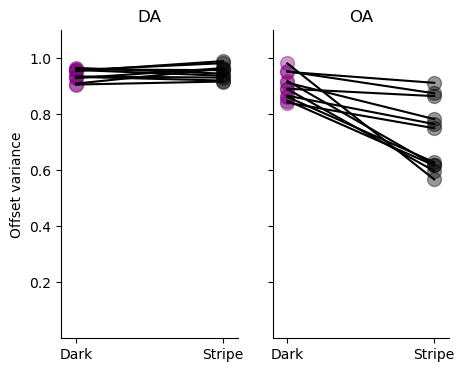

In [10]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

ax[0].set_title('DA')
ax[0].plot([0,1], da_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[0].scatter(np.zeros((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[0].scatter(np.ones((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

ax[1].set_title('OA')
ax[1].plot([0,1], oa_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[1].scatter(np.zeros((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[1].scatter(np.ones((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

for _ax in ax:
    _ax.set_ylim([0.0,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')

In [12]:
# mixed anova
da_stats_df_unique['group'] = 'DA'
oa_stats_df_unique['group'] = 'OA'

stats_df_unique = pd.concat([da_stats_df_unique,oa_stats_df_unique])
aov = mixed_anova(dv='offset_var_logit', between='group',
                  within='dark', subject='fly_id', data=stats_df_unique)
aov


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,16.546652,1,19,16.546652,33.544891,0.000014,0.638404,NaN
1,dark,2.972157,1,19,2.972157,8.626586,0.008459,0.312257,1.0
2,Interaction,6.618350,1,19,6.618350,19.209540,0.000320,0.502742,NaN


In [16]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

,Contrast,group,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,-,DA,OA,False,True,5.837844,18.934719,two-sided,0.000013,NaN,NaN,1161.993,2.429393
1,dark,-,0,1,True,True,-2.124949,20.000000,two-sided,0.046245,NaN,NaN,1.452,-0.528084
2,group * dark,DA,0,1,True,True,1.395236,9.000000,two-sided,0.196413,0.196413,holm,0.66,0.507410
3,group * dark,OA,0,1,True,True,-4.528224,10.000000,two-sided,0.001094,0.002189,holm,37.534,-1.743119


In [17]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=True)

tt

,Contrast,dark,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,dark,-,0,1,True,True,-2.124949,20.000000,two-sided,0.046245,NaN,NaN,1.452,-0.528084
1,group,-,DA,OA,False,True,5.837844,18.934719,two-sided,0.000013,NaN,NaN,1161.993,2.429393
2,dark * group,0,DA,OA,False,True,6.604572,18.870358,two-sided,0.000003,0.000005,holm,4747.651,2.767886
3,dark * group,1,DA,OA,False,True,1.886958,15.713630,two-sided,0.077782,0.077782,holm,1.304,0.770235


In [18]:
def group_rho_df(rho_stats):
    return rho_stats.groupby(['fly_id', 'cl']).apply(
    lambda x: pd.Series({
        'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
        'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)
    })).reset_index()

In [19]:
dh_bins = np.linspace(0, 3.14, num=20)

da_stats = nmp.grab_sensors.rho_stats(grabda_sess, dh_bins=dh_bins)
da_stats.loc[da_stats['cl'] > 1, 'cl'] = 1
da_grouped = group_rho_df(da_stats)

oa_stats = nmp.grab_sensors.rho_stats(graboa_sess, dh_bins=dh_bins)
oa_stats.loc[oa_stats['cl'] > 1, 'cl'] = 1
oa_grouped = group_rho_df(oa_stats)




/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:161: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:162: RuntimeWarning: Mean of empty slice.
  F_dig = np.array([ts.outer_ring[dh_dig == i].mean() for i in range(len(dh_bins))])
/tmp/ipykernel_74928/617967456.py:4: RuntimeWarning: Mean of empty slice
  'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
/tmp/ipykernel_74928/617967456.py:5: RuntimeWarning: Mean of empty slice
  'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)


Text(0.5, 0, 'rot. speed (rad/s)')

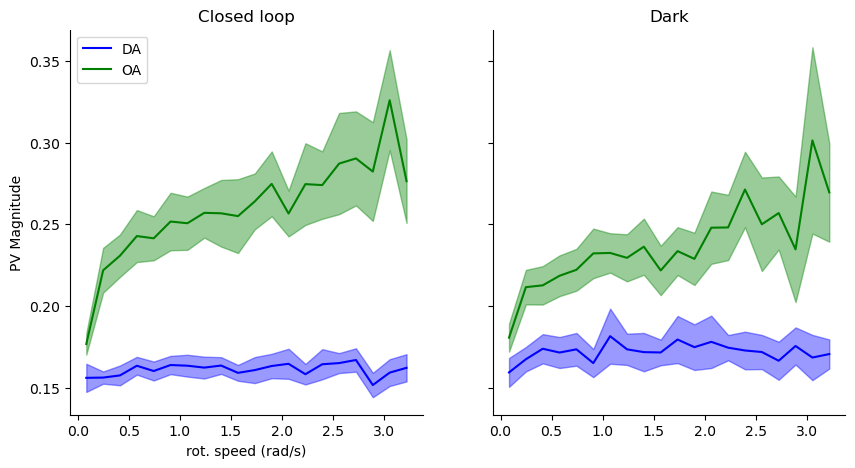

In [26]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2

fig,ax = plt.subplots(1,2,sharey=True, figsize=[10,5])

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('PV Magnitude')
ax[0].set_xlabel('rot. speed (rad/s)')

Text(0.5, 0, 'rot. speed (rad/s)')

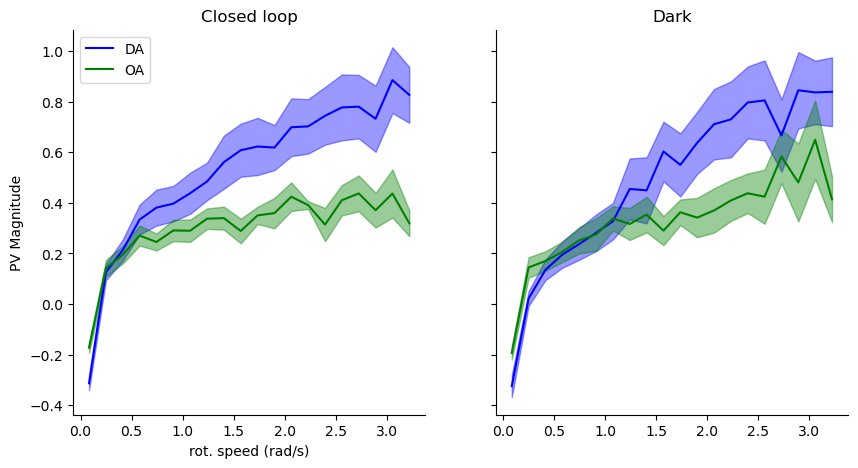

In [28]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[10,5])

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('PV Magnitude')
ax[0].set_xlabel('rot. speed (rad/s)')

KeyError: 'closed_loop'

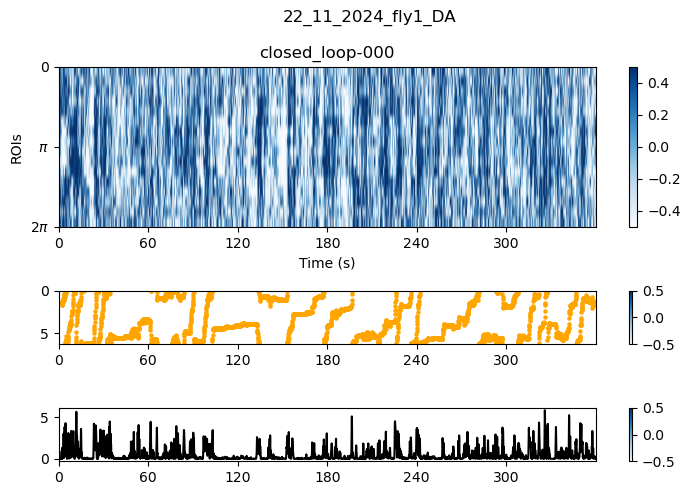

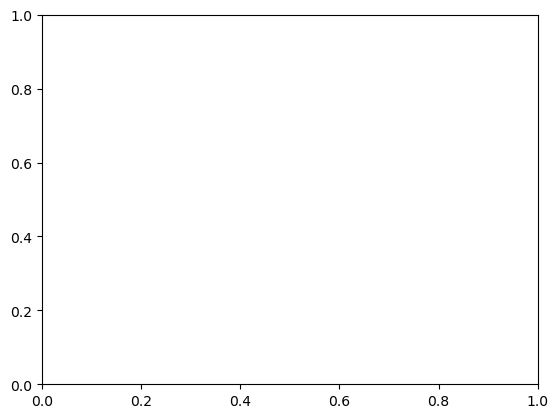

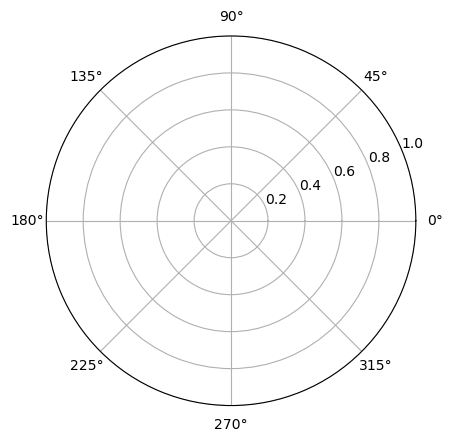

In [45]:
for _, row in grabda_sess.sess_df.iterrows():
        
    ts_dict = {'fly': row['fly_id'],
                row['session']: nmp.session.GetTS(grabda_sess.load_row(row))
    }
    
    fig_heatmaps = nmp.grab_sensors.plot_sess_heatmaps(ts_dict, cmap='Blues')
    (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.grab_sensors.plot_sess_histograms(ts_dict)